
* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


# TOC

1. *[Preprocesamiento](#preprocesamiento)*  
1.1. *[Lectura y limpieza de datos](#lectura_limpieza_datos)*  
1.2. *[Transformación Box-Cox](#transformacion_boxcox)*  
2. *[Modelo](#modelo)*  
2.1. *[ADALINE](#adaline)*  
2.2. *[ADALINE sin parámetros óptimos](#adaline_sin_parametros_optimos)*  
2.2.1. *[Precalentamiento de los pesos del ADALINE](#precalentamiento_1)*  
2.2.1. *[Entrenamiento del ADALINE](#entrenamiento_1)*  
2.2.3. *[Generar el pronóstico para los precios de los próximos siete días](#pronostico_1)*  
2.3. *[ADALINE con parámetros óptimos](#adaline_con_parametros_optimos)*  
2.3.1. *[Determinar los hiperparametros del modelo](#hiperparametros)*  
2.3.2. *[Entrenamiento y pronóstico con parámetros óptimos](#entrenamiento_pronostico)*  


In [4]:
def set_filesystem():
    try:
        from google.colab import drive
        from os import chdir
    
        drive.mount('/content/drive/', force_remount=True)
        chdir("/content/drive/My Drive/evaluacion-lfsalazarz")
    except Exception as e:
        print(e)
    
set_filesystem()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_prices(X, ext=''):
    plt.figure(figsize=(16,5))
    plt.title('Precio_Bolsa_Nacional_($kwh)' + ext)
    plt.xlabel('Días')
    plt.ylabel('kWh')
    plt.plot(X, color='black')
    plt.show();

# 1 Preprocesamiento <a class="anchor" id="preprocesamiento"></a>

## 1.1 Lectura y limpieza de datos <a class="anchor" id="lectura_limpieza_datos"></a>

**Leer los datos y almacenarlos por año**

In [3]:
dfs = {}
for year in range(1995, 2016):
    dfs[str(year)] = pd.read_excel(f'./datos/precios/Precio_Bolsa_Nacional_($kwh)_{year}.xlsx')

for year in range(2016, 2019):
    dfs[str(year)] = pd.read_excel(f'./datos/precios/Precio_Bolsa_Nacional_($kwh)_{year}.xls')

dfs.keys()

dict_keys(['1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'])

In [4]:
dfs['1995'].head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,Precio Bolsa Nacional ($/kWh) 1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fecha,0.000,1.000,2.000,3.000,4.000,5.000,6.000,7.000,8.000,...,14.000,15.000,16.000,17.000,18.000,19.000,20.000,21.000,22.000,23.000
3,1995-07-20,NaN,1.073,1.073,1.073,1.073,1.073,1.073,1.073,1.074,...,1.073,1.073,1.073,1.073,1.074,1.897,1.897,1.897,1.073,1.073
4,1995-07-21,1.073,1.000,1.000,1.000,1.000,1.000,5.000,6.000,6.000,...,5.000,1.000,1.000,5.000,12.000,16.670,11.929,5.000,1.000,1.000


**Renombrar columnas, eliminar las primeras filas inválidas, eliminar filas duplicadas y calcular el promedio por día**

**Nota**: en algunas versiones de pandas y numpy, el año 2011 se lee como una sola columna y genera error al procesar los datos. (Culpable: Excel)

In [20]:
# En colab
print(dfs['2011'].shape)
pd.__version__

(371, 1)


'0.22.0'

In [5]:
# En local
print(dfs['2011'].shape)
pd.__version__

(371, 27)


'0.24.1'

In [5]:
def preprocessing_columnsname_duplicates(df_y, year):
    df = df_y.copy()
    
    df.columns = [f'col{i}' for i in range(len(df.columns))]

    # renombrar las columnas del dataframe
    columns = np.squeeze(df.loc[df[df.columns[0]] == 'Fecha'].values)
    lindex = int(df.loc[df[df.columns[0]] == 'Fecha'].index.values) + 1
    df.columns = columns
    # eliminar las filas primeras filas inválidas
    df = df.drop(list(range(0, lindex)))
    
    # eliminar filas duplicadas
    shp_old = df.shape[0]
    df = df.drop_duplicates()
    print(f'Dataframe {year}, Final shape: {df.shape}, duplicates: {shp_old - df.shape[0]}')

    return df


def generate_average_kWh(df_y):
    # Calcular promedio de los kWh
    df = pd.DataFrame()
    df['Fecha'] = df_y['Fecha']
    df['mean'] = df_y.mean(axis=1)
    return df

In [6]:
for year in range(1995, 2019):
    year = str(year)
    dfs[year] = preprocessing_columnsname_duplicates(dfs[year], year)
    dfs[year] = generate_average_kWh(dfs[year])

Dataframe 1995, Final shape: (165, 25), duplicates: 0
Dataframe 1996, Final shape: (371, 25), duplicates: 7
Dataframe 1997, Final shape: (365, 25), duplicates: 0
Dataframe 1998, Final shape: (368, 25), duplicates: 19
Dataframe 1999, Final shape: (367, 25), duplicates: 7
Dataframe 2000, Final shape: (366, 26), duplicates: 0
Dataframe 2001, Final shape: (365, 25), duplicates: 0
Dataframe 2002, Final shape: (365, 25), duplicates: 0
Dataframe 2003, Final shape: (365, 25), duplicates: 0
Dataframe 2004, Final shape: (366, 25), duplicates: 0
Dataframe 2005, Final shape: (365, 26), duplicates: 0
Dataframe 2006, Final shape: (365, 25), duplicates: 0
Dataframe 2007, Final shape: (368, 25), duplicates: 11
Dataframe 2008, Final shape: (366, 25), duplicates: 0
Dataframe 2009, Final shape: (367, 25), duplicates: 15
Dataframe 2010, Final shape: (365, 26), duplicates: 0
Dataframe 2011, Final shape: (367, 27), duplicates: 2
Dataframe 2012, Final shape: (367, 27), duplicates: 0
Dataframe 2013, Final sha

**Concatenar los años y eliminar filas na**

In [7]:
years = sorted(list(dfs))
df_concatenated = pd.concat([dfs[y] for y in years], axis=0)

print(df_concatenated.shape)
df_concatenated = df_concatenated.dropna()
print(df_concatenated.shape)
df_concatenated.head()

df_concatenated.to_csv('preprocesamiento.csv', index=False)

(8348, 2)
(8341, 2)


In [0]:
# En caso de que la version de pandas y numpy no pueda leer correctamente el año 2011
df_concatenated = pd.read_csv('preprocesamiento.csv')

**Gráfica kWh promedio desde el año 1995 al 2018**

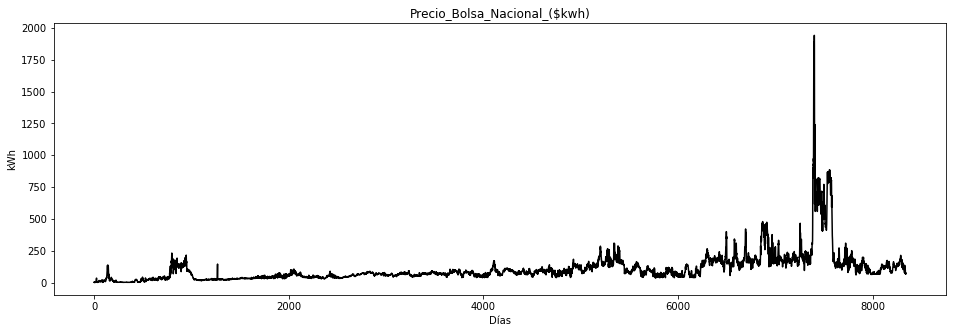

In [8]:
plot_prices(df_concatenated['mean'].values)

## 1.2 Transformación Box-Cox <a class="anchor" id="transformacion_boxcox"></a>

Las transformaciones de Box  Cox son una familia de transformaciones potenciales usadas en estadística para corregir sesgos en la distribución de errores, para corregir varianzas desiguales (para diferentes valores de la variable predictora) y principalmente para corregir la no linealidad en la relación (mejorar correlación entre las variables)...

wikipedia

In [9]:
from sklearn.preprocessing import PowerTransformer

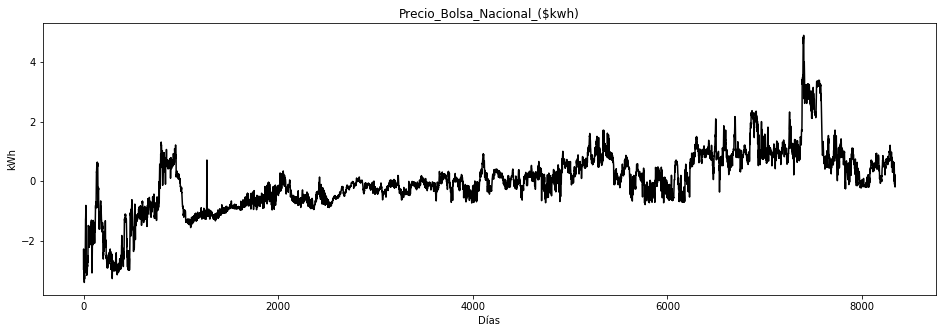

In [10]:
boxcox = PowerTransformer(method='box-cox')
x_transformed = boxcox.fit_transform(df_concatenated['mean'].values.reshape(-1, 1))
plot_prices(x_transformed)

# 2 Modelo <a class="anchor" id="modelo"></a>

## 2.1 ADALINE <a class="anchor" id="adaline"></a>

Se define el modelo ADALINE con Tensorflow en modo *eager execution*

In [11]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [12]:
class ADALINE(object):
    def __init__(self, L):
        self.w = tfe.Variable([0.0] * (L+1))

    def __call__(self, x):
        if type(x) is np.ndarray:
            x = tf.constant(np.concatenate(([1.0], x)), dtype=np.float32)
        else:
            x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred

Se definen las funciones encargadas del aprendizaje de los pesos del ADALINE y de la predicción de n días

In [13]:
seed = 12345

# función a ser optimizada
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.square(error)


# registra todas las operaciones para aplicar posteriormente el gradiente
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.w])


# retorna la función de optimización a utilizar
def get_optimizer(mu, method='gradient', momentum=0.5):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=mu)
    if method == 'momentum':
        optimizer = tf.train.MomentumOptimizer(learning_rate=mu, momentum=momentum)
    return optimizer


# pronóstico para los precios de los próximos n días
def predict_n_days(model, data, delays, ndays):
    pred = list(data[len(data) - delays:])
    for i in range(0, ndays):
        pred.append(model(pred[i:]).numpy())
    return pred, delays


def plot_y_vs_pred(y, pred):
    plt.figure(figsize=(14,3))
    plt.plot(y, color='black')
    plt.plot(pred, color='red')
    plt.show();

## 2.2 - ADALINE sin parámetros óptimos <a class="anchor" id="adaline_sin_parametros_optimos"></a>

### 2.2.1 Precalentamiento de los pesos del ADALINE <a class="anchor" id="precalentamiento_1"></a>

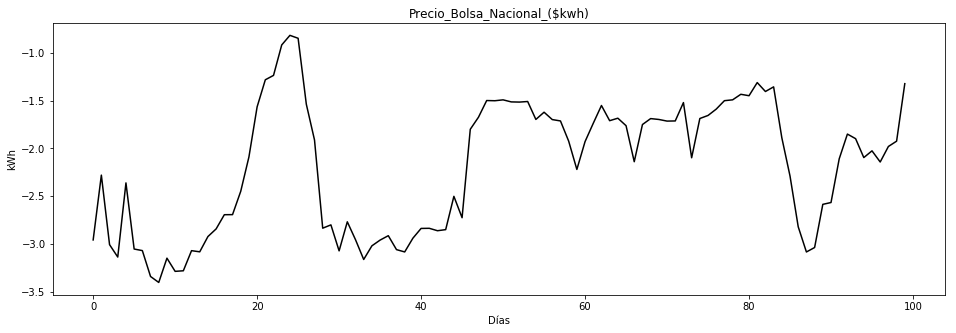

In [28]:
precalentamiento = x_transformed[0:100]
d_transformed = x_transformed[100:]
precalentamiento = precalentamiento.reshape(-1)
plot_prices(precalentamiento)

In [38]:
L = 10
epochs = 20

model = ADALINE(L)
optimizer = get_optimizer(mu=0.005)

np.random.seed(seed)
tf.set_random_seed(seed)
for _ in range(epochs):
    for t in range(L, len(precalentamiento)):
        x = precalentamiento[t-L:t]
        grads = grad(model, x, precalentamiento[t])
        optimizer.apply_gradients(zip(grads, [model.w]), global_step=tf.train.get_or_create_global_step())

print('Pesos W =', model.w.numpy())

Pesos W = [-0.45268625  0.2190333  -0.10118228 -0.0435745  -0.0030575  -0.12967964
 -0.05993795 -0.04442674 -0.03960057  0.25836003  0.5071071 ]


### 2.2.2 Entrenamiento del ADALINE <a class="anchor" id="entrenamiento_1"></a>

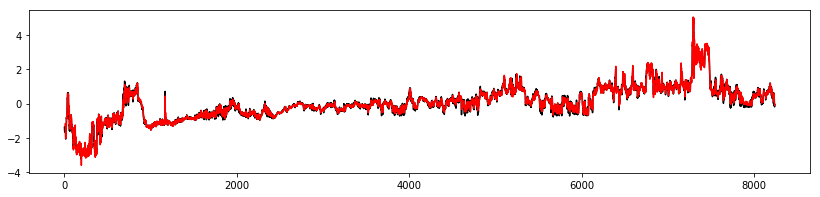

In [39]:
y_objetivo = d_transformed.reshape(-1)
y_pred = np.empty(len(y_objetivo))
y_pred[:] = np.nan

SSE = []

np.random.seed(seed)
tf.set_random_seed(seed)
for _ in range(epochs):
    _sse = 0
    for t in range(L, len(y_objetivo)):
        
        x = y_objetivo[t-L:t]
        y_pred[t] = model(x)
        _sse += loss(model, x, y_objetivo[t])
        
        grads = grad(model, x, y_objetivo[t])
        optimizer.apply_gradients(zip(grads, [model.w]), global_step=tf.train.get_or_create_global_step())
        
    SSE.append(_sse)

plot_y_vs_pred(y_objetivo, y_pred)

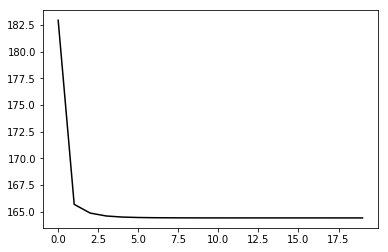

In [40]:
plt.plot(SSE, color='black');

### 2.2.3 Generar el pronóstico para los precios de los próximos siete días. <a class="anchor" id="pronostico_1"></a>

**Aplicar transformación inversa box-cox a los resultados del pronóstico**

In [41]:
result_transformed = predict_n_days(model=model, data=y_objetivo, delays=L, ndays=7)
result_inverse = boxcox.inverse_transform(np.array(result_transformed[0]).reshape(-1, 1))
result_inverse[L:]

array([[75.85492789],
       [84.73885558],
       [84.3084327 ],
       [86.04645989],
       [87.58749746],
       [86.89064681],
       [90.06762585]])

Pronóstico para los precios de los próximos siete días


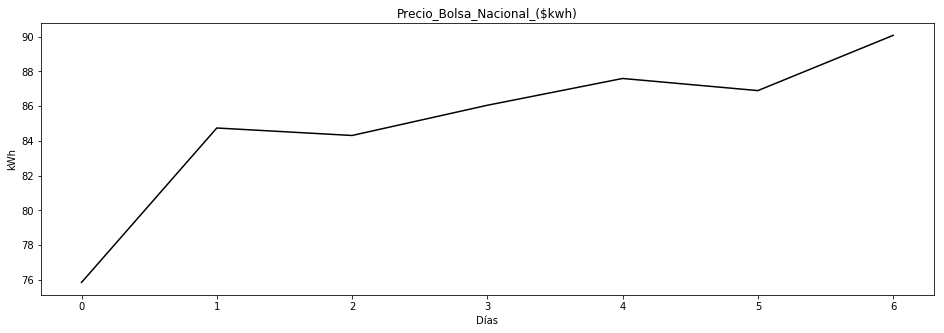

In [42]:
print('Pronóstico para los precios de los próximos siete días')
plot_prices(result_inverse[L:])

**10 días + 7 días pronósticados**

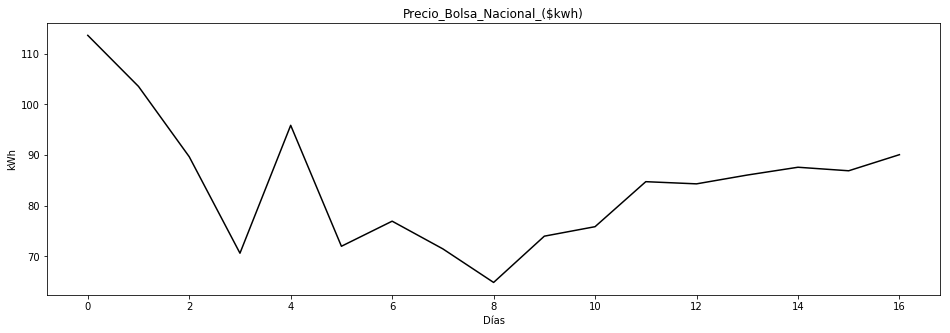

In [43]:
plot_prices(result_inverse)

## 2.3 - ADALINE con parámetros óptimos <a class="anchor" id="adaline_con_parametros_optimos"></a>

### 2.3.1 Determinar los hiperparametros del modelo <a class="anchor" id="hiperparametros"></a>

1. Se define una función que se encarga de medir el desempeño (SSE) de un modelo y retornarlo.
2. Se define una función que itera sobre los diferentes parametros de entrenamiento (L, mu, epochs) y retorna los parametros que mejor desempeño presentaron.

In [20]:
def sse_score_model(data):
    L = data['L']
    mu = data['mu']
    epochs = data['epochs']
    precalentamiento = data['precalentamiento']
    d_transformed = data['d_transformed']
    seed = data['seed']
    
    model = ADALINE(L)
    optimizer = get_optimizer(mu=mu)

    # precalentamiento
    np.random.seed(seed)
    tf.set_random_seed(seed)
    for _ in range(epochs):
        for t in range(L, len(precalentamiento)):
            x = precalentamiento[t-L:t]
            grads = grad(model, x, precalentamiento[t])
            optimizer.apply_gradients(zip(grads, [model.w]), global_step=tf.train.get_or_create_global_step())
            
    # entrenamiento
    SSE = []
    y_objetivo = d_transformed.reshape(-1)       
    np.random.seed(seed)
    tf.set_random_seed(seed)
    for _ in range(epochs):
        _sse = 0
        for t in range(L, len(y_objetivo)):
            x = y_objetivo[t-L:t]
            _sse += loss(model, x, y_objetivo[t])

            grads = grad(model, x, y_objetivo[t])
            optimizer.apply_gradients(zip(grads, [model.w]), global_step=tf.train.get_or_create_global_step())

        SSE.append(_sse)
        
    return SSE[-1].numpy()

In [21]:
def param_search(epochs, learning_rate, L, precalentamiento, d_transformed, seed):
    score_mse = []    
    
    for epoch in epochs:
        for mu in learning_rate:
            for l in L:
                result = sse_score_model({
                    'L': l,
                    'mu': mu,
                    'epochs': epoch,
                    'precalentamiento': precalentamiento,
                    'd_transformed': d_transformed,
                    'seed': seed
                })
                params = {'epochs': epoch, 'mu': mu, 'L': l}
                score_mse.append((result, params))            
                print(f"{result:<10.2f} para {params}")
    
    return score_mse

In [22]:
import time

In [0]:
start = time.time()
result = np.array(param_search(
    epochs=[1, 15, 30, 45], 
    learning_rate=[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007], 
    L=[5, 10, 15, 20, 40, 80], 
    precalentamiento=precalentamiento, 
    d_transformed=d_transformed, 
    seed=seed
))

i_min = np.argmin(result[:,0])
print(f'\nParámetros óptimos: {result[i_min, 1]}')
print(f'Tiempo total: {(time.time() - start):.2f} s')

219.85     para {'epochs': 1, 'mu': 0.001, 'L': 5}
232.03     para {'epochs': 1, 'mu': 0.001, 'L': 10}
242.10     para {'epochs': 1, 'mu': 0.001, 'L': 15}
254.86     para {'epochs': 1, 'mu': 0.001, 'L': 20}
252.52     para {'epochs': 1, 'mu': 0.001, 'L': 40}
253.31     para {'epochs': 1, 'mu': 0.001, 'L': 80}
200.94     para {'epochs': 1, 'mu': 0.002, 'L': 5}
205.90     para {'epochs': 1, 'mu': 0.002, 'L': 10}
214.72     para {'epochs': 1, 'mu': 0.002, 'L': 15}
223.46     para {'epochs': 1, 'mu': 0.002, 'L': 20}
228.84     para {'epochs': 1, 'mu': 0.002, 'L': 40}
nan        para {'epochs': 1, 'mu': 0.002, 'L': 80}
191.87     para {'epochs': 1, 'mu': 0.003, 'L': 5}
195.78     para {'epochs': 1, 'mu': 0.003, 'L': 10}
204.74     para {'epochs': 1, 'mu': 0.003, 'L': 15}
213.12     para {'epochs': 1, 'mu': 0.003, 'L': 20}
9184794749043941948394101240483545088.00 para {'epochs': 1, 'mu': 0.003, 'L': 40}
nan        para {'epochs': 1, 'mu': 0.003, 'L': 80}
186.89     para {'epochs': 1, 'mu': 0

nan        para {'epochs': 45, 'mu': 0.005, 'L': 40}
nan        para {'epochs': 45, 'mu': 0.005, 'L': 80}
166.96     para {'epochs': 45, 'mu': 0.006, 'L': 5}
442.38     para {'epochs': 45, 'mu': 0.006, 'L': 10}
nan        para {'epochs': 45, 'mu': 0.006, 'L': 15}
nan        para {'epochs': 45, 'mu': 0.006, 'L': 20}
nan        para {'epochs': 45, 'mu': 0.006, 'L': 40}
nan        para {'epochs': 45, 'mu': 0.006, 'L': 80}
167.91     para {'epochs': 45, 'mu': 0.007, 'L': 5}
964793.44  para {'epochs': 45, 'mu': 0.007, 'L': 10}
nan        para {'epochs': 45, 'mu': 0.007, 'L': 15}
nan        para {'epochs': 45, 'mu': 0.007, 'L': 20}
nan        para {'epochs': 45, 'mu': 0.007, 'L': 40}
nan        para {'epochs': 45, 'mu': 0.007, 'L': 80}

Parámetros óptimos: {'epochs': 45, 'mu': 0.001, 'L': 40}
Tiempo total: 12832.27 s


In [0]:
result[i_min]

array([155.34103, {'epochs': 45, 'mu': 0.001, 'L': 40}], dtype=object)

### 2.3.2 Entrenamiento y pronóstico con parámetros óptimos <a class="anchor" id="entrenamiento_pronostico"></a>

* L: 40
* mu: 0.001
* epochs: 45

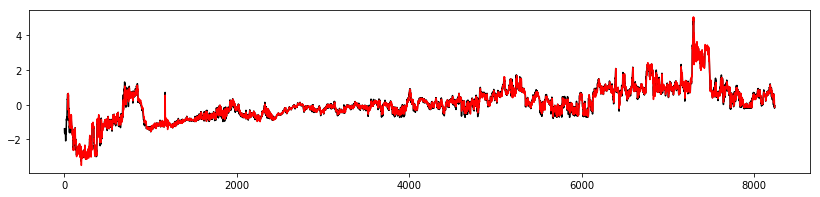

In [24]:
L = 40
epochs = 45
mu = 0.001

model = ADALINE(L)
optimizer = get_optimizer(mu=mu)

np.random.seed(seed)
tf.set_random_seed(seed)
for _ in range(epochs):
    for t in range(L, len(precalentamiento)):
        x = precalentamiento[t-L:t]
        grads = grad(model, x, precalentamiento[t])
        optimizer.apply_gradients(zip(grads, [model.w]), global_step=tf.train.get_or_create_global_step())
        
        
y_objetivo = d_transformed.reshape(-1)
y_pred = np.empty(len(y_objetivo))
y_pred[:] = np.nan

SSE = []

np.random.seed(seed)
tf.set_random_seed(seed)
for _ in range(epochs):
    _sse = 0
    for t in range(L, len(y_objetivo)):
        
        x = y_objetivo[t-L:t]
        y_pred[t] = model(x)
        _sse += loss(model, x, y_objetivo[t])
        
        grads = grad(model, x, y_objetivo[t])
        optimizer.apply_gradients(zip(grads, [model.w]), global_step=tf.train.get_or_create_global_step())
        
    SSE.append(_sse)

plot_y_vs_pred(y_objetivo, y_pred)

In [25]:
result_transformed = predict_n_days(model=model, data=y_objetivo, delays=L, ndays=7)
result_inverse = boxcox.inverse_transform(np.array(result_transformed[0]).reshape(-1, 1))
result_inverse[L:]

array([[71.75316415],
       [85.11844494],
       [86.45611598],
       [89.91914129],
       [88.10400365],
       [84.38913417],
       [82.12346855]])

Pronóstico para los precios de los próximos siete días


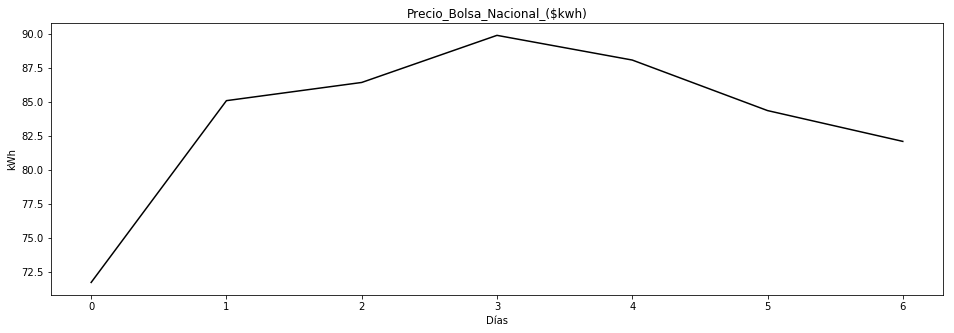

In [26]:
print('Pronóstico para los precios de los próximos siete días')
plot_prices(result_inverse[L:])

**40 días + 7 días pronósticados**

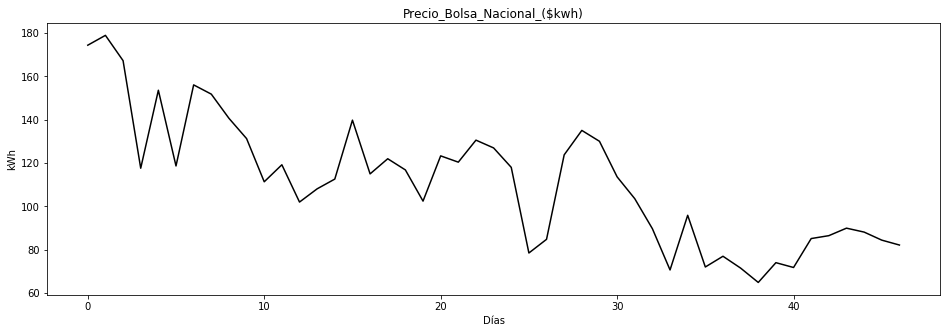

In [27]:
plot_prices(result_inverse)